In [71]:
import QuantLib as ql
from QuantLib import *
from fredapi import Fred
fred = Fred(api_key='177ad7df08f3dc82a72e19844c282ad7')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.interpolate import CubicSpline
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
plt.style.use(style="seaborn")
%matplotlib inline

C:\Users\HPELIT~1\AppData\Local\Temp/ipykernel_6844/632660257.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [188]:
sofr

<QuantLib.QuantLib.OvernightIndex; proxy of <Swig Object of type 'ext::shared_ptr< OvernightIndex > *' at 0x000002AF01B59B60> >

In [177]:
Calendar = ql.UnitedStates(ql.UnitedStates.NYSE) #ql.UnitedStates()
DayCount=ql.Actual360()
SwapDayCount=ql.Thirty360(ql.Thirty360.BondBasis) #ql.Thirty360()
Freq=ql.Semiannual
BusDayConv = ql.ModifiedFollowing
DateGeneration = ql.DateGeneration.Backward
MonthEndFlag = False
EvaluationDate = ql.Date(7,2, 2022)
SpotDate=ql.Date(9,2,2022)
ql.Settings.instance().evaluationDate = EvaluationDate
libor3m=ql.USDLibor(ql.Period(3, ql.Months))
libor6m=ql.USDLibor(ql.Period(6, ql.Months))
libor1m=ql.USDLibor(ql.Period(1, ql.Months))
sofr = ql.OvernightIndex("SOFR", 2, ql.USDCurrency(), Calendar, DayCount)

In [31]:
libor1m.fixingCalendar().

<QuantLib.QuantLib.Calendar; proxy of <Swig Object of type 'Calendar *' at 0x0000026331C393E0> >

In [5]:
deposits = pd.DataFrame(columns=['value'],data= fred.get_series('SNDR')) #.loc['2020-11-01':'01/04/2022'] #National Deposit Rates
SWP5 = pd.DataFrame(columns=['value'],data= fred.get_series('MSWP5')) 
SWP1 = pd.DataFrame(columns=['value'],data= fred.get_series('MSWP1')) 
SWP2 = pd.DataFrame(columns=['value'],data= fred.get_series('MSWP2')) 
SWP3 = pd.DataFrame(columns=['value'],data= fred.get_series('MSWP3')) 
SWP4 = pd.DataFrame(columns=['value'],data= fred.get_series('MSWP4')) 
SWP5 = pd.DataFrame(columns=['value'],data= fred.get_series('MSWP5')) 
SWP7 = pd.DataFrame(columns=['value'],data= fred.get_series('MSWP7')) 
SWP30 = pd.DataFrame(columns=['value'],data= fred.get_series('MSWP30')) 
instruments_str = ["deposits", "SWP5", "SWP1", "SWP2", "SWP3", "SWP4", "SWP5", "SWP7", "SWP30"]

In [6]:
inst = {"deposits" : deposits, "SWP5" :SWP5, "SWP1" :SWP1, "SWP2" : SWP2, "SWP3" : SWP3, "SWP4": SWP4,"SWP5": SWP5,"SWP7": SWP7,"SWP30": SWP30}
instruments = [deposits, SWP5, SWP1, SWP2, SWP3, SWP4, SWP5, SWP7, SWP30]

In [4]:
dates = set.intersection(set(SWP1.index), set(SWP3.index), set(SWP4.index), set(SWP5.index), set(SWP7.index), set(SWP30.index), set(SWP2.index))

In [6]:
dates

{Timestamp('2000-07-01 00:00:00'),
 Timestamp('2000-08-01 00:00:00'),
 Timestamp('2000-09-01 00:00:00'),
 Timestamp('2000-10-01 00:00:00'),
 Timestamp('2000-11-01 00:00:00'),
 Timestamp('2000-12-01 00:00:00'),
 Timestamp('2001-01-01 00:00:00'),
 Timestamp('2001-02-01 00:00:00'),
 Timestamp('2001-03-01 00:00:00'),
 Timestamp('2001-04-01 00:00:00'),
 Timestamp('2001-05-01 00:00:00'),
 Timestamp('2001-06-01 00:00:00'),
 Timestamp('2001-07-01 00:00:00'),
 Timestamp('2001-08-01 00:00:00'),
 Timestamp('2001-09-01 00:00:00'),
 Timestamp('2001-10-01 00:00:00'),
 Timestamp('2001-11-01 00:00:00'),
 Timestamp('2001-12-01 00:00:00'),
 Timestamp('2002-01-01 00:00:00'),
 Timestamp('2002-02-01 00:00:00'),
 Timestamp('2002-03-01 00:00:00'),
 Timestamp('2002-04-01 00:00:00'),
 Timestamp('2002-05-01 00:00:00'),
 Timestamp('2002-06-01 00:00:00'),
 Timestamp('2002-07-01 00:00:00'),
 Timestamp('2002-08-01 00:00:00'),
 Timestamp('2002-09-01 00:00:00'),
 Timestamp('2002-10-01 00:00:00'),
 Timestamp('2002-11-

In [10]:
maturity = ['2002-07-01','2003-01-01','2003-07-01','2004-01-01','2005-01-01','2006-01-01','2007-01-01',
                         '2008-01-01','2009-01-01','2010-01-01','2011-01-01','2012-01-01','2013-01-01','2014-01-01',
                         '2016-01-01']

In [6]:
data = pd.DataFrame(data = maturity,index = maturity, columns=["d"])

In [191]:
# Define the market data
# Input convention: (Instrument, fwd start, tenor, rate)

yts = ql.RelinkableYieldTermStructureHandle()

# Input market observables here
# Using the SimpleQuote structure helps in bumping rates later by leveraging SimpleQuote methods
rates = {
    ('Deposit', None, '1M'): ql.SimpleQuote(0.01),
    ('Deposit', None, '2M'): ql.SimpleQuote(0.01),
    ('FRA', 3, 6): ql.SimpleQuote(0.0105),
    ('FRA', 6, 9): ql.SimpleQuote(0.011),
    ('FRA', 9, 12): ql.SimpleQuote(0.0115),
    ('FRA', 12, 15): ql.SimpleQuote(0.012),
    ('FRA', 15, 18): ql.SimpleQuote(0.012),
    ('FRA', 18, 21): ql.SimpleQuote(0.0125),
    ('FRA', 21, 24): ql.SimpleQuote(0.0125),
    ('Swap', '0D' , '2Y'): ql.SimpleQuote(0.0117),
    ('Swap', '0D' , '3Y'): ql.SimpleQuote(0.0117),
    ('Swap', '0D' , '4Y'): ql.SimpleQuote(0.0115),
    ('Swap', '0D' , '5Y'): ql.SimpleQuote(0.0115),
    ('Swap', '0D' , '7Y'): ql.SimpleQuote(0.0115),
    ('Swap', '0D' , '10Y'): ql.SimpleQuote(0.012),
    ('Swap', '0D' , '12Y'): ql.SimpleQuote(0.012),
    ('Swap', '0D' , '15Y'): ql.SimpleQuote(0.012),
    ('Swap', '0D' , '20Y'): ql.SimpleQuote(0.012),
    ('Swap', '0D' , '25Y'): ql.SimpleQuote(0.012),
    ('Swap', '0D' , '30Y'): ql.SimpleQuote(0.012)
}

# Helpers contain info about the instruments used to define the curve
rateHelper = ql.RateHelperVector()

# The conventions to use
index = ql.Euribor3M(yts)
calendar = ql.TARGET()
convention = ql.Following
dayCount = ql.Actual360()
fixingDays = 0
fixedFrequency=ql.Annual
fixedDayCount = ql.Thirty360(ql.Thirty360.BondBasis)
 
# Loop through input rates and add to rateHelper
for v in rates.keys():
    inst, fwd_start, tenor = v
    rate = rates[v]
    
    # If it's a depo then use the DepositRateHelper class
    if inst == 'Deposit':
        rateHelper.append(ql.DepositRateHelper(ql.QuoteHandle(rate),
                                               ql.Period(tenor),
                                               fixingDays,
                                               calendar,
                                               convention,
                                               False,
                                               dayCount))
    
    # If a FRA then use the FraRateHelper method
    if inst == 'FRA':
        rateHelper.append(ql.FraRateHelper(ql.QuoteHandle(rate),
                                           fwd_start,
                                           tenor,
                                           fixingDays,
                                           calendar,
                                           convention,
                                           False,
                                           dayCount))
    
    # If a swap then use the SwapRateHelper method
    if inst == 'Swap':
        rateHelper.append(ql.SwapRateHelper(ql.QuoteHandle(rate),
                                            ql.Period(tenor),
                                            calendar,
                                            fixedFrequency,
                                            convention,
                                            fixedDayCount,
                                            index,
                                            ql.QuoteHandle(ql.SimpleQuote(0.0)),
                                            ql.Period(fwd_start)))

In [209]:
# Build a bunch of curves using the same inputs but different interps
today = ql.Date(14,3,2021)

params = [today, rateHelper, dayCount]

curves = {
'Linear Interpolation': ql.LinearInterpolation(X, Y),
'CubicNaturalSpline': ql.CubicNaturalSpline(X, Y),
'ForwardFlatInterpolation': ql.ForwardFlatInterpolation(X, Y),
'BackwardFlatInterpolation': ql.BackwardFlatInterpolation(X, Y)}

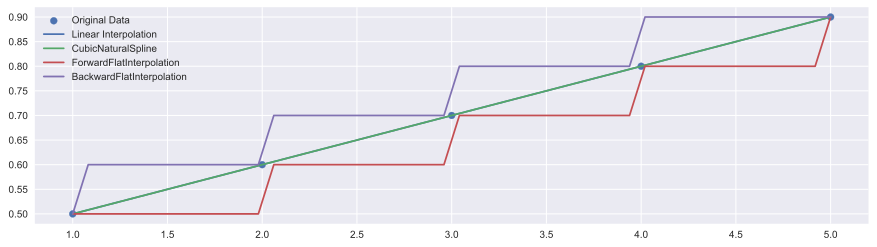

In [210]:
X = [1., 2., 3., 4., 5.]
Y = [0.5, 0.6, 0.7, 0.8, 0.9]
xx = np.linspace(1, 5)
fig = plt.figure(figsize=(15,4))
plt.scatter(X, Y, label='Original Data')
for name, i in curves.items():
    yy = [i(x, allowExtrapolation=True) for x in xx]
    plt.plot(xx, yy, label=name)
plt.legend()

***Spline Cubic :***
*Courbe du taux*

In [67]:
rates = pd.read_csv("rates.csv").iloc[:,:2].set_index("Tickers")

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

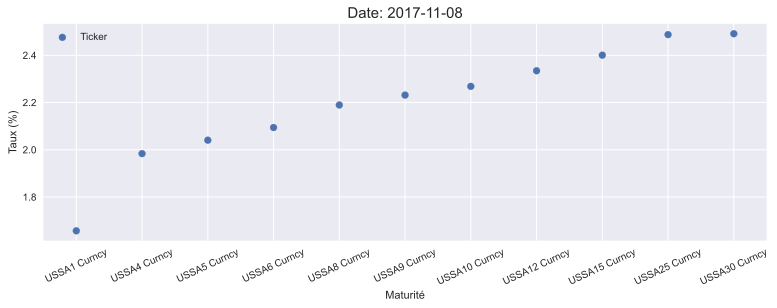

In [89]:
plt.figure(figsize=(13,4))
plt.scatter(rates.index, rates.Rates, label = 'Ticker')
plt.xlabel('Maturité')
plt.ylabel('Taux (%)')
plt.title('Date: 2017-11-08', fontsize = 15)
plt.legend()
plt.xticks(rotation=25)

#sns.scatterplot(data=rates)

In [114]:
np.array(time_T)*30

array([ 0.99,  3.96,  4.92,  5.91,  7.89,  8.88,  9.87, 11.85, 14.79,
       24.66, 29.58])

In [129]:
time_T

[12.0, 48.0, 60.0, 72.0, 96.0, 108.0, 120.0, 144.0, 180.0, 300.0, 360.0]

In [130]:
time_T = list()
for ticker in rates.index:
    time_T.append(np.round(np.array(float(ticker[4:6]))*12/365, 3))

In [131]:
cs = CubicSpline(time_T, rates.Rates)
curve_points = np.linspace(min(time_T), max(time_T), 100)

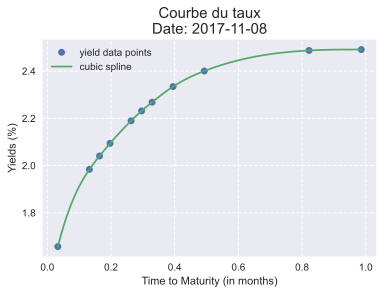

In [132]:
plt.figure()
plt.title('Courbe du taux\nDate: 2017-11-08', fontsize = 15)
plt.xlabel('Time to Maturity (in months)')
plt.ylabel('Yields (%)')
plt.plot(time_T, rates.Rates, 'o', label = 'yield data points')
plt.plot(curve_points, cs(curve_points), label="cubic spline")
plt.grid(linestyle = '--', linewidth = 1)
plt.legend()
plt.show()

In [144]:
tenors = np.array([3/12*12, 1*12, 24, 3*12, 4*12, 5*12, 6*12, 7*12, 8*12, 9*12, 10*12, 15*12,27*12])/365
maturities_btw_each_tenors = np.array([1.5*12, 2.5*12, 3.5*12, 4.5*12, 5.5*12, 6.5*12, 7.5*12, 8.5*12, 9.5*12, 12.5*12, 19.5*12])/365

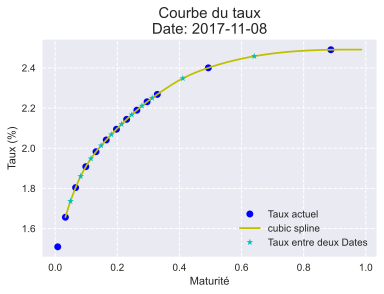

In [146]:
plt.figure()
plt.title('Courbe du taux\nDate: 2017-11-08', fontsize = 15)
plt.xlabel('Maturité')
plt.ylabel('Taux (%)')
plt.plot(tenors, cs(tenors), 'o', color = 'b', label = 'Taux actuel')
plt.plot(curve_points, cs(curve_points), color = 'y', label="cubic spline")
plt.plot(maturities_btw_each_tenors, cs(maturities_btw_each_tenors), '*', color = 'c', label="Taux entre deux Dates")
plt.grid(linestyle = '--', linewidth = 1)
plt.legend()
plt.show()